In [1]:
import gc
import multiprocessing
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prfs, accuracy_score
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

In [4]:
df_features = pd.read_csv("../../curated-data/ModelData_SR20.csv")
df_features.head(5)

,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,Task,...,NP,FA,SR,AP,AR,DWH,DWR,T,DS,Rank
0,24,38,2,8,10,3,8,16,17,26,...,2,1,1,2,4,2,70,1,1,2
1,17,35,6,9,7,4,8,25,14,31,...,2,1,1,2,5,2,70,1,1,1
2,20,38,8,8,6,5,7,19,22,29,...,1,2,1,2,4,2,90,2,2,0
3,16,54,3,7,3,9,6,23,24,16,...,2,1,0,2,2,2,60,1,2,0
4,18,28,6,4,10,3,8,13,12,35,...,1,2,1,2,5,1,60,2,1,2


In [3]:
df.SR.value_counts()

1    200
0    199
Name: SR, dtype: int64

In [40]:
# df_features = df[['NCP', 'TA', 'T', 'H', 'EXT', 'NASA', 'Task', 'AV', 'DWR', 'AGR', 'OP', 'TWR', 'SR']].copy()
# df_features = df[['NCP', 'TA', 'CR', 'EXT', 'Task', 'NASA', 'H', 'DWR', 'T', 'AV', 'AGR', 'OP', 'DS', 'SR']].copy()

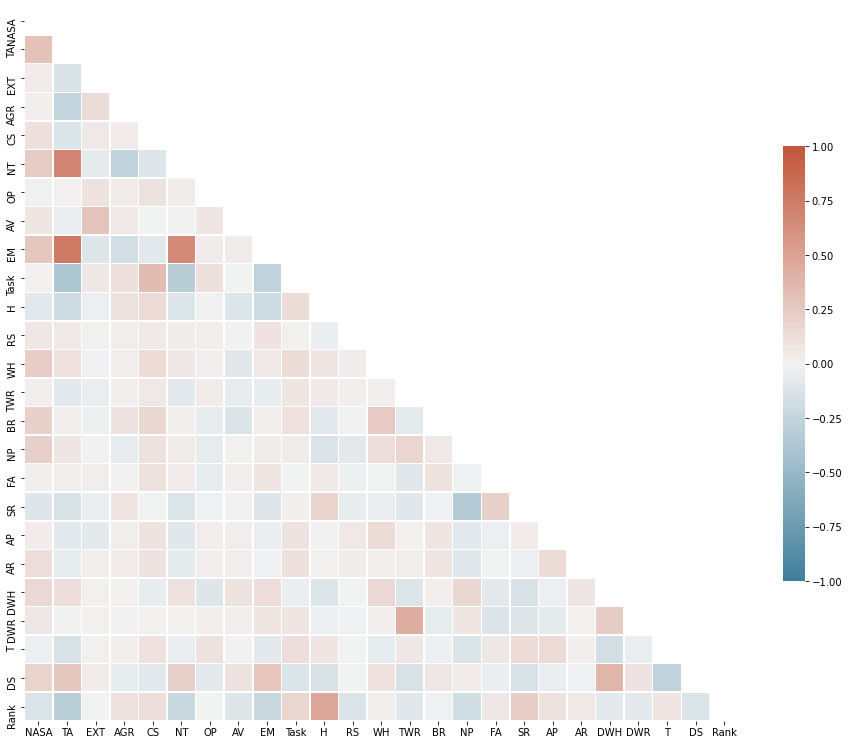

In [5]:
corr = df_features.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(16, 16))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_features, df_features['SR']):
    strat_train_set = df_features.loc[train_index]
    strat_test_set = df_features.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

In [7]:
%%time
# rf = RandomForestClassifier(n_estimators = 1600, max_features = 'auto', bootstrap = True)
rf = RandomForestClassifier(n_estimators = 1600, max_features = 'auto', bootstrap = True)

Wall time: 989 µs


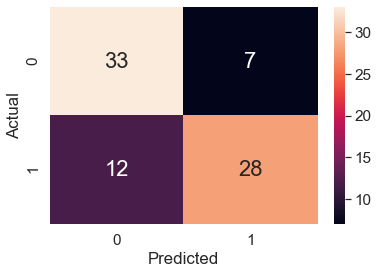

In [8]:
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 22}) # font size
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [9]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.7625
Precision:  0.8
Recall:  0.7
F1:  0.7466666666666666
Auc Score:  0.8225


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [11]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [12]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': False}

In [51]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
    print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    accuracy = metrics.accuracy_score(Y_test, predictions)
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 1600, max_features = 'auto', bootstrap = True)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_test, Y_test)

Model Performance
Accuracy = 0.80%.


In [52]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, Y_test)

Model Performance
Accuracy = 0.80%.


In [53]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=10,
                       n_estimators=1600)

In [54]:
rf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=10,
                       n_estimators=1600)

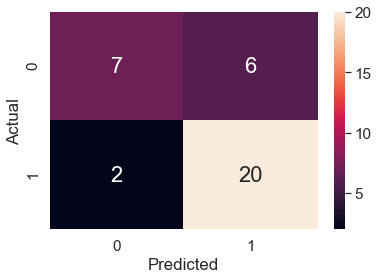

In [55]:
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 22}) # font size
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [22]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.8
Precision:  0.7777777777777778
Recall:  0.9545454545454546
F1:  0.8571428571428572
Auc Score:  0.8321678321678322


In [23]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [100, 110, 120, 130],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1400, 1600, 1800, 2000]
}


# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [24]:
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  4.7min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [100, 110, 120, 130],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [1400, 1600, 1800, 2000]},
             verbose=2)

In [25]:
grid_search.best_params_

{'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 1800}

In [26]:
rf = RandomForestClassifier(max_depth=100,min_samples_leaf = 1, min_samples_split = 12, n_estimators=1800)

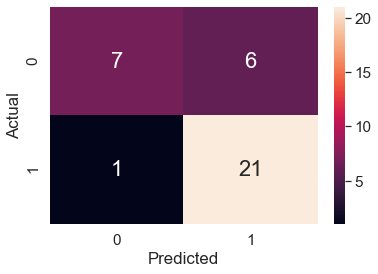

In [27]:
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 22}) # font size
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [28]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.8
Precision:  0.7777777777777778
Recall:  0.9545454545454546
F1:  0.8571428571428572
Auc Score:  0.8286713286713286
